# Machine learning tutorial at CMSDAS at CERN, June 2024
## Exercise 2: binary classification

Evan Armstrong Koenig, Matthias Komm, Pietro Vischia

The core of this tutorial comes from https://github.com/vischia/data_science_school_igfae2024 (Pietro Vischia (pietro.vischia@cern.ch)).

The CMSDAS version extends it to consider a convolutional network to regress Higgs quantities, plus some fixes.


In [1]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/data_science_school_igfae2024.git
#%cd machine_learning_tutorial
#!pwd
#!ls
#!pip install livelossplot shap

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14

import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc
from tqdm import tqdm

from scipy.optimize import newton
from scipy.stats import norm

import uproot

import datetime
from timeit import default_timer as timer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

import pandas as pd


## Neural networks

#### Details on neural networks

Biology teaches us that the brain is constituted of neurons and connections between them: the synapses.
By comparing the brain of various animals, we now think that the more the number of neurons and most importantly of synapses is large, the more complex are the functions that the brain can execute.

Let's learn the inner workings of a very simplified mathematical model of brain: an artificual neural network.

The first element is the neuron. The simplest model (and one of the first) we have is the [*perceptron*](https://en.wikipedia.org/wiki/Perceptron). The neuron is modelled by a mathematical function that takes some arguments as inputs, combines them linearly, and returns an output value.
We denote as *weights* the coefficients of the linear combination.

However, we want to be able to approximate nonlinear functions, so we need to plug in a degree of nonlinearity inside the neuron, and we want the neuron to fire only when a certain threshold in the output is reached (a certain amount of stimulation).

We modify the output of the neuron by an activation function $f_{act}$: the neuron is activated if the activation function returns a non-zero value. The output of the neuron is defined as:

$$
y_n = f_{act}(\sum_i w_{i,n} x_{i,n})
$$

If the activation function is not linear, we are happy because we have obtained a neuron that gives a nonlinear output and gets activated only if the stimuli it receives are large enough.

The activation function become larger than 0.5 at $x=0$. We need to include the possibility of shifting the value for which the neuron activates. This is done by introducing a bias. The neuron output, that we wrote above as

$$
y_n = f_{act}(\sum_i w_{i,n} x_{i,n})
$$

(that activates for $\sum(w_i x_i)>0$) will be

$$
y_n = f_{act}(\sum_i w_{i,n} x_{i,n} + w_{bb})
$$

that activates at a learnable ($w_b$) value. 


You will use in this exercise mostly two activation functions:

- [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a function $f(x)$ that returns 0 if $x<0$, and $x$ otherwise;
- [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), a function that rescales any number into a number between 0 and 1.

Here you have a graphical representation of the perceptron, by [https://towardsdatascience.com](https://towardsdatascience.com):

![neuron](https://miro.medium.com/max/1435/1*n6sJ4yZQzwKL9wnF5wnVNg.png "Figure from https://towardsdatascience.com")

Now we have to connect the neurons. The simplest way is to build layers of neurons, and to connect all neurons of consecutive layers. Starting with the inputs, there is a first layer of neurons. Each neuron combines linearly the inputs and passes the result through activation function to give an output value. The set of outputs of a layer will be the input of the following layer:

![neuralnet](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/800px-Colored_neural_network.svg.png "Figure from wikipedia")

A neural network is characterized by a set of weights assigned to the connections that define the structure of the network. You can see this as a mathematical function with many free parameters (the weights) that takes the inputs and gives an output. The problem of learning is then the problem of finding the values of the free parameters that minimize the difference between the output and the target distribution that we want to learn.


#### The training process

Schematically, the training process consists in:

- for each epoch
   * for each training set data point:
      1. calculate the output of each neuron, starting from the inputs to the output
      2. compare the output of the last neuron with the reference wine quality
      3. propagate the error back towards the inputs, without updating the weights (the error needs to be propagated with respect to the current values of the weights)
      4. update all the weights
      5. save the value of the loss function for each event
   * for each test set data point:
      1. save the value of the loss function for each event
   * aggregate the errors by computing a Mean Squared Average (MSE)
      1. the MSE of the errors in the training dataset events is the average training loss
      2. the MSE of the errors in the test dataset is the averate validation loss (you see here I am using validation and test indifferently)

The idea is the training will stop when the loss function doesn't improve anymore (it remains stationary at its minimum. If the training loss keeps diminishing and the test loss begins increasing, then we might be starting to learn statistical fluctuations of the training dataset.


#### Clarification on the connections between networks (to fix ideas)

If the network has the following structure: (input layer: two inputs `A` et `B`;  first internal (_hidden_) layer: two neurons `1a` et `1b`; second hidden layer: two neurons `2a` et `2b`; output `y`), the list of connections (the weights) is:

- Four weights connecting the inputs to the layer 1:
    - `wA1a` (connects input `A` to neuron `1a`)
    - `wA1b` (connects input `A` to neuron `1b`)
    - `wB1a` (connects input `B` to neuron `1a`)
    - `wB1b` (connects input `B` to neuron `1b`)
- Four weights connecting the neurons of layer 1 to those of layer 2:_
    - `W1a2a` (connects neuron `1a` to neuron `2a`)
    - `W1a2b` (connects neuron `1a` to neuron `2b`)
    - `W1b2a` (connects neuron `1b` to neuron `2a`)
    - `W1b2b` (connects neuron `1b` to neuron `2b`)
- Two weights connecting the neurons of layer 2 to the output y:
    - `W2ay` (connects neuron `2a` to output `y`)
    - `W2by` (connects neuron `2b` to output `y`)

####  Backpropagation

To perform backpropagation we need, for each neuron, to propagate back the error of the neurons of the following layer (so you need to go backwards). We use the chain rule.

- Error for a neuron of the output layer:

$$
\epsilon = (y_{true} - \hat{y}) * activation\_derivative(\hat{y})
$$

Here $\hat{y}$ is the output of this output neuron, and $y_{true}$ is the target quality of the wine

- Error for a neuron $m$ of an internal layer $N$:

$$
\epsilon_{m, N} = \sum_{k} (w_{k, N+1} * \epsilon_{k, N+1}) * activation\_derivative(\hat{m})
$$

Here, $\epsilon_{k,N+1}$ is the error of the neuron $k$ of the following layer (layer $N+1$), $w_{k, N+1}$ is the weight of the connection between the neuron $m$ and the neuron $k$ of the next layer, and $\hat{m}$ is the output of neuron $m$


#### Updating the weights

After having backpropagated all the gradient, you have to update all the weights using this formula:

$$
w = w + learning\_rate * erreur * input
$$

Ici $erreur$ is the error calculated via backpropagation, $input$ is the input value of the neuron that had been originally passed to the neuron, and $learning rate$ is a parameter governing how fast we climb down the gradient.

 
#### At the end of each epoch

To check for convergence of the network, a standard practice is to aggregeate the errors $\hat{y} - y_{true}$  of all the events at the end of each epoch, in order to reduce the sensitivity to statistical fluctuations in the training sample. The first pillar of statistical wisdom according to Stigler is precisely aggregation. 

In analogy with $\chi^2$ fit, we can for example calculate the $MSE = \frac{1}{N} \sum_{events} (\hat{y}-y_{true})^2$ and plot the MSE as a function of the number of epochs. If the network is improving its predictions, we should see something like this:

![mse](https://cern.ch/vischia/mse_pythonCourse.png "Figure by Pietro Vischia, 2019")

#### Diagnostic plots

- 1) MSE as a function of the epoch
- 2) Histogram of $\frac{\hat{y} - y_{true}}{y_{true}}$ 
- 3) Histogram of $\frac{\hat{y} - y_{true}}{y_{true}}$ as a function of $y_{true}$


### Weights initialization
- To initialize the weights at the beginning you can use a Gaussian, or a truncated gaussian ( (scipy.stats.truncnorm), or a $random uniform[0,1]$


In [3]:
import torchinfo
import torch
torch.manual_seed(0)

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

Let's briefly see how `torch`deals with gradients

Let's calculate gradients of a simple equation using autodiff

In [4]:
x0 = torch.tensor(1., requires_grad=True)
x1 = torch.tensor(2., requires_grad=True)
print("x0 = ",x0)
print("x1 = ",x1)

p = 2*x0 + x0*torch.sin(x1) + x1**3
print("p = ",p)

p.backward()
print("dp/dx0 = ",x0.grad)
print("dp/dx1 = ", x1.grad)

x0 =  tensor(1., requires_grad=True)
x1 =  tensor(2., requires_grad=True)
p =  tensor(10.9093, grad_fn=<AddBackward0>)
dp/dx0 =  tensor(2.9093)
dp/dx1 =  tensor(11.5839)


In [5]:
#compare with analytic solution
x0_grad_analytic = 2+torch.sin(x1)
x1_grad_analytic = x0*torch.cos(x1)+3*x1**2

print("dp/dx0 = ",x0_grad_analytic)
print("dp/dx1 = ",x1_grad_analytic)

dp/dx0 =  tensor(2.9093, grad_fn=<AddBackward0>)
dp/dx1 =  tensor(11.5839, grad_fn=<AddBackward0>)


Now let's try to redefine the function, but this time we will use the `sin` function from the `math` library instead of the `torch` library.

Do you think this will make a difference? Let's try!

In [6]:
p = 2*x0 + x0*math.sin(x1) + x1**3
print(p)
p.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)
tensor(5.8186) tensor(23.5839)


It is important to use operations that have been overloaded within the library: implement the same equation, but this time the function `sin` is imported from `math`.

Notice how no error message is thrown, but gradients are completely different. This is because `torch`is blind to the portion of equation involving `math.sin`, in the sense that it cannot anymore propagate the gradient through it.

Now let's plot some activation function.

Let's also plot the derivative of each activation function, in two ways: by plotting the explicitly coded derivative function, and by plotting the derivative computed via automatic differentiation, `x.grad`.

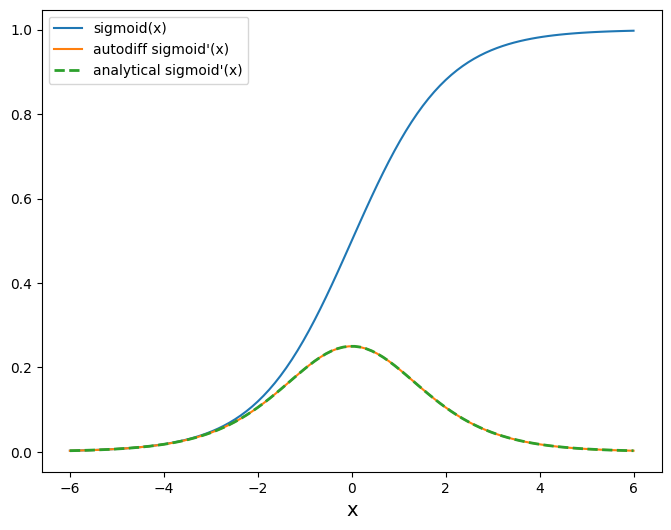

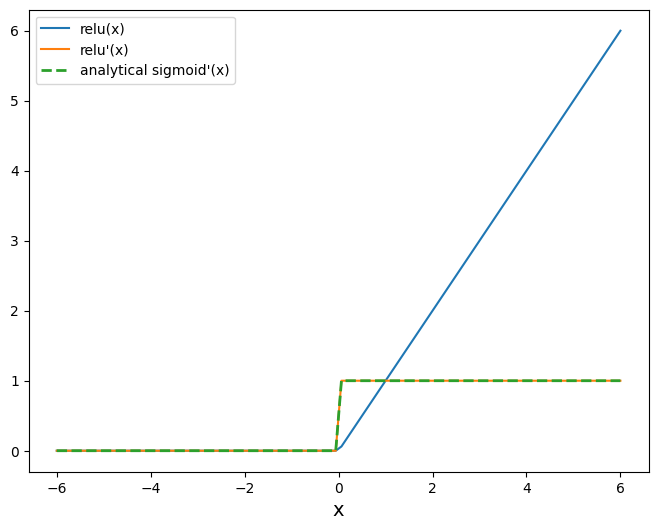

In [7]:
x = torch.tensor(np.linspace(-6, 6, 100), requires_grad=True)
y = torch.sigmoid(x)
yprime = lambda x: torch.sigmoid(x)*(1-torch.sigmoid(x))

func, =plt.plot(x.detach().numpy(),y.detach().numpy(), label="sigmoid(x)")
plt.xlabel("x")
Y = torch.sum(y)
Y.backward()
derivative, =plt.plot(x.detach().numpy(),x.grad.detach().numpy(), label="autodiff sigmoid'(x)")
anal_derivative = plt.plot(x.detach().numpy(), yprime(x).detach().numpy(), label="analytical sigmoid'(x)", linestyle='--', linewidth=2)

plt.legend()
plt.show()
plt.close()

plt.figure()
x = torch.tensor(np.linspace(-6, 6, 100), requires_grad=True)
y =torch.relu(x)
yprime = lambda x: torch.where(x>0, 1,0) 

func, = plt.plot(x.detach().numpy(),y.detach().numpy(), label="relu(x)")
plt.xlabel("x")
Y = torch.sum(y)
Y.backward()
derivative, =plt.plot(x.detach().numpy(),x.grad.detach().numpy(), label="relu'(x)")
anal_derivative = plt.plot(x.detach().numpy(), yprime(x).detach().numpy(), label="analytical sigmoid'(x)", linestyle='--', linewidth=2)
plt.legend()
plt.show()
plt.close()

# Import data

We will use simulated events corresponding to three physics processes.

- ttH production
- ttW production
- Drell-Yan production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%;"/>


In [8]:
INPUT_FOLDER = '/cmsuf/data/store/user/ekoenig/cmsdas/2024/short-ex-mlg'
sig = uproot.open(os.path.join(INPUT_FOLDER,'signal.root'))['Friends'].arrays(library="pd")
bk1 = uproot.open(os.path.join(INPUT_FOLDER,'background_1.root'))['Friends'].arrays(library="pd")
bk2 = uproot.open(os.path.join(INPUT_FOLDER,'background_2.root'))['Friends'].arrays(library="pd")

## Data inspection

We will now apply in one go all the manipulations of the input dataset that we have seen yesterday

First we drop all features that either correspond to unwanted objects (third lepton) or to labels we will need later on for regression.

In [9]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )

Now we add the labels for classification...

In [10]:
signal['label'] = 1
bkg = pd.concat([bkg1, bkg2])
bkg['label'] = 0
data = pd.concat([signal,bkg]).sample(frac=1).reset_index(drop=True)
X = data.drop(["label"], axis=1)
y = data["label"]

and we split the data into training and test dataset.
Let's also go straight to the downsampling (you can run on your own on the whole training dataset, but for this demonstration we don't need to do that).

In [11]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
print(f"We have {len(X_train)} training samples with {sum(y_train)} signal and {sum(1-y_train)} background events")
print(f"We have {len(X_test)} testing samples with {sum(y_test)} signal and {sum(1-y_test)} background events")

Ntrain=10000
Ntest=2000
X_train = X_train[:Ntrain]
y_train = y_train[:Ntrain]
X_test = X_test[:Ntest]
y_test = y_test[:Ntest]

# LABEL OF THIS PLACE HERE, WILL BE USEFUL LATER

We have 1266862 training samples with 200729 signal and 1066133 background events
We have 623977 testing samples with 98558 signal and 525419 background events


For neural networks we will use `pytorch`, a backend designed natively for tensor operations.
I prefer it to tensorflow, because it exposes (i.e. you have to call them explicitly in your code) the optimizer steps and the backpropagation steps.

You could also use the `tensorflow` backend, either directly or through the `keras` frontend.
Saying "I use keras" does not tell you which backend is being used. It used to be either `tensorflow` or `theano`. Nowadays `keras` is I think almost embedded inside tensorflow, but it is still good to specify.

`torch` handles the data management via the `Dataset` and `DataLoader` classes.
Here we don't need any specific `Dataset` class, because we are not doing sophisticated things, but you may need that in the future.

The `Dataloader` class takes care of providing quick access to the data by sampling batches that are then fed to the network for (mini)batch gradient descent.

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

batch_size=512 # Minibatch learning


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([512, 27])
Labels batch shape: torch.Size([512])


For educational purposes, let's get access the data loader via its iterator, and sample a single batch by calling `next` on the iterator

In [13]:
random_batch_X, random_batch_y = next(iter(train_dataloader))
print(random_batch_X.shape, random_batch_y.shape) 

torch.Size([512, 27]) torch.Size([512])


Let's build a simple neural network, by inheriting from the `nn.Module` class. **This is very crucial, because that class is the responsible for providing the automatic differentiation infrastructure for tracking parameters and performing backpropagation**

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.device = device
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

Let's instantiate the neural network and print some info on it

In [15]:
model = NeuralNetwork(X_train.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, X_train.shape[1])) # the input size is (batch size, number of features)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=27, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [512, 1]                  --
├─Sequential: 1-1                        [512, 1]                  --
│    └─Linear: 2-1                       [512, 512]                14,336
│    └─ReLU: 2-2                         [512, 512]                --
│    └─Linear: 2-3                       [512, 128]                65,664
│    └─ReLU: 2-4                         [512, 128]                --
│    └─Linear: 2-5                       [512, 64]                 8,256
│    └─ReLU: 2-6                         [512, 64]                 --
│    └─Linear: 2-7                       [512, 8]                  520
│    └─ReLU: 2-8                         [512, 8]                  --
│    └─Linear: 2-9                       [512, 1]                  9
│    └─Sigmoid: 2-10                     [512, 1]                  --
Total params: 88,785
Trainable params: 88,785
Non-trainable params: 0
Tota

Now let's introduce a crucial concept: `torch` lets you manage in which device you want to put your data and models, to optimize access at different stages

In [16]:
device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
if torch.cuda.is_available() and torch.cuda.device_count()>0:
    device = torch.device("cuda")
    
print ("Available device: ",device)


# Get a batch from the dataloader
random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The original dataloader resides in", random_batch_X.get_device())

# Let's reinstantiate the dataset
train_dataset = MyDataset(X_train, y_train, device=device)
test_dataset = MyDataset(X_test, y_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The new dataloader puts the batches in in", random_batch_X.get_device())

# Reinstantiate the model, on the chosen device
model = NeuralNetwork(X_train.shape[1], device)

#check if the NN can be evaluated some data; note: it has not been trained yet
print (model(torch.tensor(X_train.values[:10],device=device)))

Available device:  cpu
The original dataloader resides in -1
The new dataloader puts the batches in in -1
tensor([[0.2797],
        [0.2027],
        [0.3770],
        [0.1995],
        [0.1076],
        [0.0972],
        [0.1645],
        [0.2824],
        [0.3474],
        [0.3633]], grad_fn=<SigmoidBackward0>)


We have learned how load the data into the GPU, how to define and instantiate a model. Now we need to define a training loop.

In `keras`, this is wrapped hidden into the `.fit()` method, which I think is bad because it hides the actual procedure.

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

Now we need to define the loop that is run on the test dataset.

**The test dataset is just used for evaluating the output of the model. No backpropagation is needed, therefore backpropagation must be switched off!!!**

In [18]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for X, y in dataloader:
        for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

We are now read to train this!
At the moment we are trying to do classification. We will set our loss function to be the cross entropy.

Torch provides the functionality to use generic functions as loss function. We will show an example one.

In [19]:

loss_fn = torch.nn.BCELoss()
#loss_fn = torch.nn.CrossEntropyLoss()

#loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
def CPloss(y_hat,y):
    loss = torch.mean( y[:,0]*torch.pow( y_hat - y[:,1], 2))
    #quad=-1,2
    #lin=-2,1
    #sm=-3,0
    return loss
# We would use this loss function in the same way as the other predefined loss functions:
# loss_fn=CPloss


Time to define optimizer and scheduler, number of epochs, and finally to train!

In [20]:
epochs=100
learningRate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.71it/s]


Avg train loss 0.6314214 , Avg test loss 0.38359484821558 Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 410.28it/s]


Avg train loss 0.33086035 , Avg test loss 0.3731682375073433 Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 419.57it/s]


Avg train loss 0.3276948 , Avg test loss 0.35138121247291565 Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 436.87it/s]


Avg train loss 0.32202405 , Avg test loss 0.34854038804769516 Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 436.32it/s]


Avg train loss 0.3193406 , Avg test loss 0.34638626128435135 Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.58it/s]


Avg train loss 0.31665376 , Avg test loss 0.3456665873527527 Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.63it/s]


Avg train loss 0.31701472 , Avg test loss 0.34138213843107224 Current learning rate [0.004782969000000002]
Epoch 8
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.58it/s]


Avg train loss 0.316991 , Avg test loss 0.34102778881788254 Current learning rate [0.004304672100000002]
Epoch 9
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.70it/s]


Avg train loss 0.31470034 , Avg test loss 0.34240997582674026 Current learning rate [0.003874204890000002]
Epoch 10
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.70it/s]


Avg train loss 0.31430414 , Avg test loss 0.34529996663331985 Current learning rate [0.003486784401000002]
Epoch 11
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.14it/s]


Avg train loss 0.31346378 , Avg test loss 0.33852314949035645 Current learning rate [0.003138105960900002]
Epoch 12
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.20it/s]


Avg train loss 0.31263453 , Avg test loss 0.34040725231170654 Current learning rate [0.0028242953648100018]
Epoch 13
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.33it/s]


Avg train loss 0.31137183 , Avg test loss 0.34051885455846786 Current learning rate [0.0025418658283290017]
Epoch 14
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.85it/s]


Avg train loss 0.3118599 , Avg test loss 0.33908988535404205 Current learning rate [0.0022876792454961017]
Epoch 15
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.74it/s]


Avg train loss 0.31123713 , Avg test loss 0.33924419432878494 Current learning rate [0.0020589113209464917]
Epoch 16
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.58it/s]


Avg train loss 0.3103869 , Avg test loss 0.3389059156179428 Current learning rate [0.0018530201888518425]
Epoch 17
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.13it/s]


Avg train loss 0.31047648 , Avg test loss 0.33824338763952255 Current learning rate [0.0016677181699666583]
Epoch 18
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 436.97it/s]


Avg train loss 0.31030434 , Avg test loss 0.3368605598807335 Current learning rate [0.0015009463529699924]
Epoch 19
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.79it/s]


Avg train loss 0.31075096 , Avg test loss 0.3366542384028435 Current learning rate [0.0013508517176729932]
Epoch 20
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 424.55it/s]


Avg train loss 0.310248 , Avg test loss 0.3373933508992195 Current learning rate [0.001215766545905694]
Epoch 21
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 426.68it/s]


Avg train loss 0.31017485 , Avg test loss 0.33876457065343857 Current learning rate [0.0010941898913151245]
Epoch 22
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 423.50it/s]


Avg train loss 0.3098387 , Avg test loss 0.3359232246875763 Current learning rate [0.0009847709021836122]
Epoch 23
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.68it/s]


Avg train loss 0.310139 , Avg test loss 0.33832481503486633 Current learning rate [0.0008862938119652509]
Epoch 24
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 425.21it/s]


Avg train loss 0.3093838 , Avg test loss 0.3380938023328781 Current learning rate [0.0007976644307687258]
Epoch 25
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.05it/s]


Avg train loss 0.30899972 , Avg test loss 0.33864251524209976 Current learning rate [0.0007178979876918532]
Epoch 26
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.32it/s]


Avg train loss 0.30843583 , Avg test loss 0.33651353418827057 Current learning rate [0.0006461081889226679]
Epoch 27
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.81it/s]


Avg train loss 0.3094552 , Avg test loss 0.3369796648621559 Current learning rate [0.0005814973700304011]
Epoch 28
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 434.86it/s]


Avg train loss 0.3094494 , Avg test loss 0.3359442800283432 Current learning rate [0.0005233476330273611]
Epoch 29
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.25it/s]


Avg train loss 0.308748 , Avg test loss 0.3361765667796135 Current learning rate [0.000471012869724625]
Epoch 30
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 426.01it/s]


Avg train loss 0.30882272 , Avg test loss 0.336994007229805 Current learning rate [0.0004239115827521625]
Epoch 31
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 415.01it/s]


Avg train loss 0.30845138 , Avg test loss 0.3370979279279709 Current learning rate [0.00038152042447694626]
Epoch 32
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 423.98it/s]


Avg train loss 0.30836082 , Avg test loss 0.33637573570013046 Current learning rate [0.00034336838202925164]
Epoch 33
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.41it/s]


Avg train loss 0.30872387 , Avg test loss 0.33666858822107315 Current learning rate [0.0003090315438263265]
Epoch 34
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 425.17it/s]


Avg train loss 0.30924448 , Avg test loss 0.335876040160656 Current learning rate [0.00027812838944369386]
Epoch 35
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.35it/s]


Avg train loss 0.30945867 , Avg test loss 0.3374704495072365 Current learning rate [0.0002503155504993245]
Epoch 36
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.78it/s]


Avg train loss 0.30957237 , Avg test loss 0.33583783358335495 Current learning rate [0.00022528399544939206]
Epoch 37
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.96it/s]


Avg train loss 0.3088269 , Avg test loss 0.33618583530187607 Current learning rate [0.00020275559590445286]
Epoch 38
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.49it/s]


Avg train loss 0.30789176 , Avg test loss 0.33670689910650253 Current learning rate [0.00018248003631400757]
Epoch 39
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.93it/s]


Avg train loss 0.3083897 , Avg test loss 0.33620642125606537 Current learning rate [0.00016423203268260683]
Epoch 40
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.56it/s]


Avg train loss 0.30935726 , Avg test loss 0.3364986777305603 Current learning rate [0.00014780882941434616]
Epoch 41
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.09it/s]


Avg train loss 0.3096295 , Avg test loss 0.3364647775888443 Current learning rate [0.00013302794647291155]
Epoch 42
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 427.51it/s]


Avg train loss 0.30770344 , Avg test loss 0.33620916306972504 Current learning rate [0.00011972515182562039]
Epoch 43
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 427.29it/s]


Avg train loss 0.30902597 , Avg test loss 0.33532045781612396 Current learning rate [0.00010775263664305835]
Epoch 44
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 423.62it/s]


Avg train loss 0.30811974 , Avg test loss 0.3355100750923157 Current learning rate [9.697737297875251e-05]
Epoch 45
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 408.74it/s]


Avg train loss 0.30839956 , Avg test loss 0.3360160365700722 Current learning rate [8.727963568087727e-05]
Epoch 46
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 423.82it/s]


Avg train loss 0.31024784 , Avg test loss 0.3366200402379036 Current learning rate [7.855167211278955e-05]
Epoch 47
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.56it/s]


Avg train loss 0.30868426 , Avg test loss 0.3357182517647743 Current learning rate [7.06965049015106e-05]
Epoch 48
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.81it/s]


Avg train loss 0.3087281 , Avg test loss 0.336773619055748 Current learning rate [6.362685441135955e-05]
Epoch 49
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 436.35it/s]


Avg train loss 0.30834252 , Avg test loss 0.3366212472319603 Current learning rate [5.7264168970223595e-05]
Epoch 50
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 425.42it/s]


Avg train loss 0.3080199 , Avg test loss 0.33583498001098633 Current learning rate [5.153775207320124e-05]
Epoch 51
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 434.08it/s]


Avg train loss 0.30878174 , Avg test loss 0.33557530492544174 Current learning rate [4.6383976865881114e-05]
Epoch 52
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.90it/s]


Avg train loss 0.31120387 , Avg test loss 0.33588917553424835 Current learning rate [4.1745579179293e-05]
Epoch 53
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.47it/s]


Avg train loss 0.30977413 , Avg test loss 0.335821270942688 Current learning rate [3.75710212613637e-05]
Epoch 54
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.49it/s]


Avg train loss 0.3079866 , Avg test loss 0.33662909269332886 Current learning rate [3.381391913522733e-05]
Epoch 55
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 427.53it/s]


Avg train loss 0.30910578 , Avg test loss 0.33556126803159714 Current learning rate [3.0432527221704597e-05]
Epoch 56
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.44it/s]


Avg train loss 0.3083726 , Avg test loss 0.33748120814561844 Current learning rate [2.7389274499534138e-05]
Epoch 57
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.93it/s]


Avg train loss 0.30817991 , Avg test loss 0.33579031378030777 Current learning rate [2.4650347049580723e-05]
Epoch 58
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 426.11it/s]


Avg train loss 0.30896258 , Avg test loss 0.33497124165296555 Current learning rate [2.218531234462265e-05]
Epoch 59
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 426.36it/s]


Avg train loss 0.30864167 , Avg test loss 0.33565258979797363 Current learning rate [1.9966781110160387e-05]
Epoch 60
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.87it/s]


Avg train loss 0.3096309 , Avg test loss 0.33478671312332153 Current learning rate [1.797010299914435e-05]
Epoch 61
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.49it/s]


Avg train loss 0.30841142 , Avg test loss 0.3364802673459053 Current learning rate [1.6173092699229914e-05]
Epoch 62
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.08it/s]


Avg train loss 0.3098319 , Avg test loss 0.3364538550376892 Current learning rate [1.4555783429306922e-05]
Epoch 63
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.10it/s]


Avg train loss 0.30859 , Avg test loss 0.33571500331163406 Current learning rate [1.310020508637623e-05]
Epoch 64
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.73it/s]


Avg train loss 0.3089065 , Avg test loss 0.33607060462236404 Current learning rate [1.1790184577738607e-05]
Epoch 65
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 89.13it/s]


Avg train loss 0.30879116 , Avg test loss 0.33676355332136154 Current learning rate [1.0611166119964747e-05]
Epoch 66
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.71it/s]


Avg train loss 0.30780503 , Avg test loss 0.3356199413537979 Current learning rate [9.550049507968273e-06]
Epoch 67
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 447.40it/s]


Avg train loss 0.30819383 , Avg test loss 0.3355376869440079 Current learning rate [8.595044557171446e-06]
Epoch 68
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 280.47it/s]


Avg train loss 0.30809978 , Avg test loss 0.3364231139421463 Current learning rate [7.735540101454301e-06]
Epoch 69
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 437.75it/s]


Avg train loss 0.31036752 , Avg test loss 0.335773803293705 Current learning rate [6.9619860913088715e-06]
Epoch 70
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.35it/s]


Avg train loss 0.3091335 , Avg test loss 0.33676881343126297 Current learning rate [6.265787482177985e-06]
Epoch 71
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.35it/s]


Avg train loss 0.30957526 , Avg test loss 0.3361392691731453 Current learning rate [5.639208733960187e-06]
Epoch 72
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 436.86it/s]


Avg train loss 0.3087452 , Avg test loss 0.3355604037642479 Current learning rate [5.075287860564168e-06]
Epoch 73
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 437.46it/s]


Avg train loss 0.30919266 , Avg test loss 0.335072785615921 Current learning rate [4.5677590745077515e-06]
Epoch 74
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.84it/s]


Avg train loss 0.30777562 , Avg test loss 0.3359057456254959 Current learning rate [4.110983167056976e-06]
Epoch 75
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.49it/s]


Avg train loss 0.30851328 , Avg test loss 0.3355512171983719 Current learning rate [3.6998848503512788e-06]
Epoch 76
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 437.25it/s]


Avg train loss 0.3081096 , Avg test loss 0.33598584681749344 Current learning rate [3.329896365316151e-06]
Epoch 77
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.61it/s]


Avg train loss 0.30956745 , Avg test loss 0.33604855090379715 Current learning rate [2.9969067287845362e-06]
Epoch 78
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 427.78it/s]


Avg train loss 0.30880606 , Avg test loss 0.3353397324681282 Current learning rate [2.6972160559060827e-06]
Epoch 79
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.40it/s]


Avg train loss 0.30791 , Avg test loss 0.3361116945743561 Current learning rate [2.4274944503154745e-06]
Epoch 80
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.31it/s]


Avg train loss 0.30762038 , Avg test loss 0.33558328449726105 Current learning rate [2.1847450052839273e-06]
Epoch 81
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 427.47it/s]


Avg train loss 0.308199 , Avg test loss 0.33623581379652023 Current learning rate [1.9662705047555346e-06]
Epoch 82
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.24it/s]


Avg train loss 0.30795532 , Avg test loss 0.3369280621409416 Current learning rate [1.7696434542799813e-06]
Epoch 83
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.49it/s]


Avg train loss 0.3083533 , Avg test loss 0.33558665215969086 Current learning rate [1.5926791088519833e-06]
Epoch 84
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 409.06it/s]


Avg train loss 0.30828452 , Avg test loss 0.33524222671985626 Current learning rate [1.433411197966785e-06]
Epoch 85
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 437.92it/s]


Avg train loss 0.30673915 , Avg test loss 0.33672112971544266 Current learning rate [1.2900700781701065e-06]
Epoch 86
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.21it/s]


Avg train loss 0.30851954 , Avg test loss 0.3364727720618248 Current learning rate [1.161063070353096e-06]
Epoch 87
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.05it/s]


Avg train loss 0.3078373 , Avg test loss 0.3350074216723442 Current learning rate [1.0449567633177863e-06]
Epoch 88
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 433.99it/s]


Avg train loss 0.30914488 , Avg test loss 0.3355051726102829 Current learning rate [9.404610869860078e-07]
Epoch 89
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.45it/s]


Avg train loss 0.3079129 , Avg test loss 0.3361618220806122 Current learning rate [8.46414978287407e-07]
Epoch 90
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 437.60it/s]


Avg train loss 0.3086545 , Avg test loss 0.3359682559967041 Current learning rate [7.617734804586663e-07]
Epoch 91
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 430.72it/s]


Avg train loss 0.30800396 , Avg test loss 0.3358876183629036 Current learning rate [6.855961324127997e-07]
Epoch 92
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 429.76it/s]


Avg train loss 0.3093061 , Avg test loss 0.33642076700925827 Current learning rate [6.170365191715197e-07]
Epoch 93
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 432.55it/s]


Avg train loss 0.3080584 , Avg test loss 0.3357698619365692 Current learning rate [5.553328672543678e-07]
Epoch 94
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 435.29it/s]


Avg train loss 0.30856472 , Avg test loss 0.3363237977027893 Current learning rate [4.99799580528931e-07]
Epoch 95
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 421.38it/s]


Avg train loss 0.30733174 , Avg test loss 0.33522410690784454 Current learning rate [4.498196224760379e-07]
Epoch 96
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 412.77it/s]


Avg train loss 0.3085874 , Avg test loss 0.3358868882060051 Current learning rate [4.0483766022843414e-07]
Epoch 97
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 435.01it/s]


Avg train loss 0.30727732 , Avg test loss 0.33538103848695755 Current learning rate [3.643538942055907e-07]
Epoch 98
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 428.39it/s]


Avg train loss 0.3095445 , Avg test loss 0.3344327434897423 Current learning rate [3.2791850478503163e-07]
Epoch 99
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 437.97it/s]


Avg train loss 0.30877656 , Avg test loss 0.3354356735944748 Current learning rate [2.951266543065285e-07]
Epoch 100
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 431.29it/s]

Avg train loss 0.3078093 , Avg test loss 0.3361919969320297 Current learning rate [2.6561398887587566e-07]
Done!


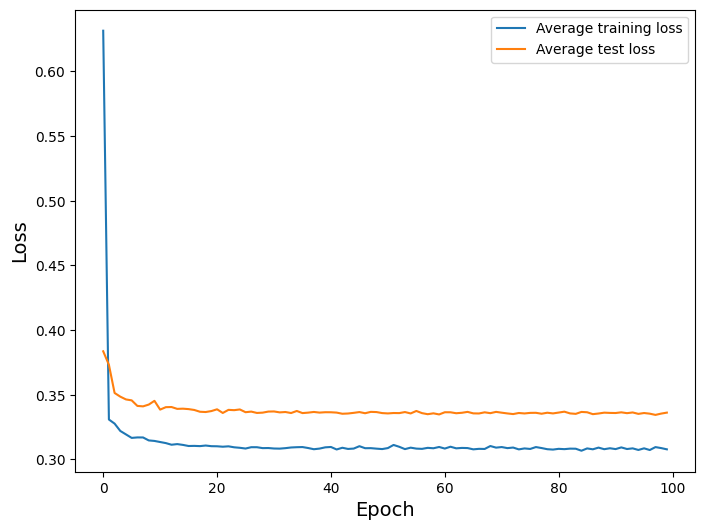

In [21]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

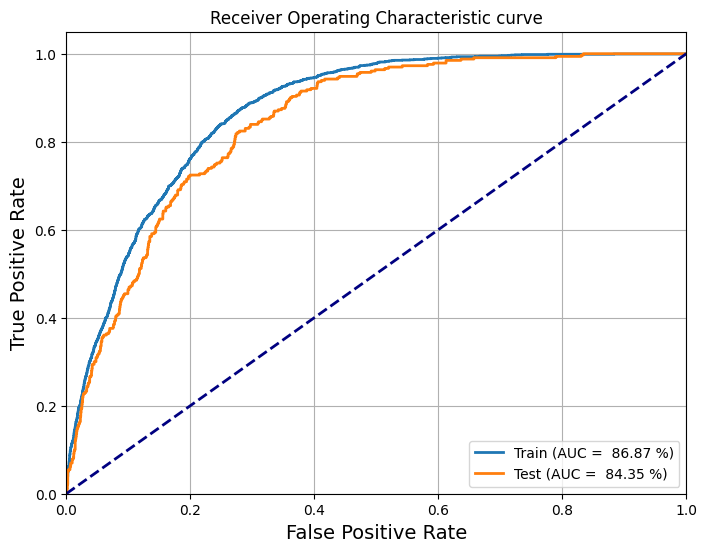

In [22]:
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score)
        plt.plot(
            fpr, tpr, 
            linewidth=2, 
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

plot_rocs([
    (model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True), y_train, "Train"), 
    (model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True), y_test, "Test")  
])

## WHOOPS! The network is not learning anything!!!

What can we do?

Go back to that cell that had this text: `# LABEL OF THIS PLACE HERE, WILL BE USEFUL LATER`
and add there the following lines:

```
from sklearn.preprocessing import StandardScaler

for column in X_train.columns:
    scaler = StandardScaler().fit(X_train[column])
    X_train[column] = scaler.transform(X_train[column])
    X_test[column] = scaler.transform(X_test[column])
```

You could also use the basic syntax recommended by the documentation, as follows, but then you would be standardizing all the features to exacly the same mean. This may work for some data sets, but for this specific one it does not (it actually significantly worsens the performance---you can try ;) ).

```
scaler = StandardScaler().fit(X_train)

X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
```

Rerun starting from that cell, and now check the new loss function evolution.

#### Can you explain what is the effect of these lines and their effect on the gradient descent?

### The end